In [15]:
 # !pip install pandas scikit-learn nltk

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import time
import matplotlib.pyplot as plt 
import string
from collections import Counter

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [17]:
file_path = r'D:\Codes\NewsClassifier\News_Category_Dataset_v3.json'
df2 = pd.read_json(file_path, lines=True)
df2['text'] = df2['headline'] + " " + df2['short_description']
df2 = df2[['category', 'text']]

{'U.S. NEWS': 1377, 'COMEDY': 5400, 'PARENTING': 8791, 'WORLD NEWS': 3299, 'CULTURE & ARTS': 1074, 'TECH': 2104, 'SPORTS': 5077, 'ENTERTAINMENT': 17362, 'POLITICS': 35602, 'WEIRD NEWS': 2777, 'ENVIRONMENT': 1444, 'EDUCATION': 1014, 'CRIME': 3562, 'SCIENCE': 2206, 'WELLNESS': 17945, 'BUSINESS': 5992, 'STYLE & BEAUTY': 9814, 'FOOD & DRINK': 6340, 'MEDIA': 2944, 'QUEER VOICES': 6347, 'HOME & LIVING': 4320, 'WOMEN': 3572, 'BLACK VOICES': 4583, 'TRAVEL': 9900, 'MONEY': 1756, 'RELIGION': 2577, 'LATINO VOICES': 1130, 'IMPACT': 3484, 'WEDDINGS': 3653, 'COLLEGE': 1144, 'PARENTS': 3955, 'ARTS & CULTURE': 1339, 'STYLE': 2254, 'GREEN': 2622, 'TASTE': 2096, 'HEALTHY LIVING': 6694, 'THE WORLDPOST': 3664, 'GOOD NEWS': 1398, 'WORLDPOST': 2579, 'FIFTY': 1401, 'ARTS': 1509, 'DIVORCE': 3426}


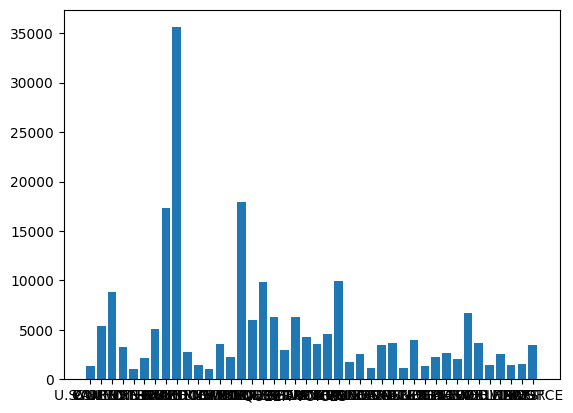

In [ ]:
#issue 1 - visualising the distriubution of all classes in the dataset. 
category_count = {}
classes = []
for i in df2['category']:
    if i in category_count:
        category_count[i] += 1
    else:
        category_count[i] = 1
        classes.append(i)
print(category_count)

plt.bar(range(len(category_count)), list(category_count.values()), align='center')
plt.xticks(range(len(category_count)), list(category_count.keys()))
plt.show()

In [ ]:
#removing minor classes
low_count_category = set()
for i , j in category_count.items():
    if j < 4000:
        low_count_category.add(i)
        classes.remove(i)
print(len(low_count_category))
print(len(category_count))

print(len(df2.index))
indices = df2[df2['category'].isin(low_count_category)].index
df2.drop(indices, inplace=True)
print(len(df2.index))


28
42
209527
144167


In [ ]:
stop_words = set(stopwords.words('english'))
#ref- stopwords is an inbuilt fn which has repitiive words like this, or, that, and etc. 

category_freq_dict = {}

for category, group in df2.groupby('category'):
    full_text = ' '.join(group['text'].astype(str).tolist())
    tokens = nltk.word_tokenize(full_text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in string.punctuation and token not in stop_words]
    counter = Counter(tokens)
    top_words = [word for word, freq in counter.most_common(10)]  # or whatever number
    category_freq_dict[category] = set(top_words)

def preprocess_text(text,category):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    filtered = [token for token in tokens if token not in category_freq_dict.get(category, set())]
    return ' '.join(filtered)

df2['processed_text'] = df2.apply(lambda row: preprocess_text(row['text'], row['category']), axis=1)
#ref- apply means it will loop through everything in the dataframe and apply the specified fn to each and every one. 

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df2['processed_text'], df2['category'], test_size=0.2)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', MultinomialNB()),
]) 

In [55]:
print("Training the model...")
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

print("Making predictions...")
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Training the model...
Training completed in 2.65 seconds (0.04 minutes)
Making predictions...
Accuracy: 0.6622

Classification Report:
                precision    recall  f1-score   support

  BLACK VOICES       0.81      0.11      0.20       926
      BUSINESS       0.78      0.27      0.40      1220
        COMEDY       0.79      0.24      0.36      1067
 ENTERTAINMENT       0.61      0.78      0.68      3544
  FOOD & DRINK       0.76      0.64      0.69      1277
HEALTHY LIVING       0.71      0.04      0.08      1343
 HOME & LIVING       0.86      0.44      0.58       842
     PARENTING       0.71      0.55      0.62      1750
      POLITICS       0.68      0.94      0.79      7087
  QUEER VOICES       0.79      0.28      0.41      1291
        SPORTS       0.80      0.41      0.54       983
STYLE & BEAUTY       0.77      0.72      0.74      1935
        TRAVEL       0.74      0.73      0.74      2010
      WELLNESS       0.53      0.87      0.66      3559

      accuracy         

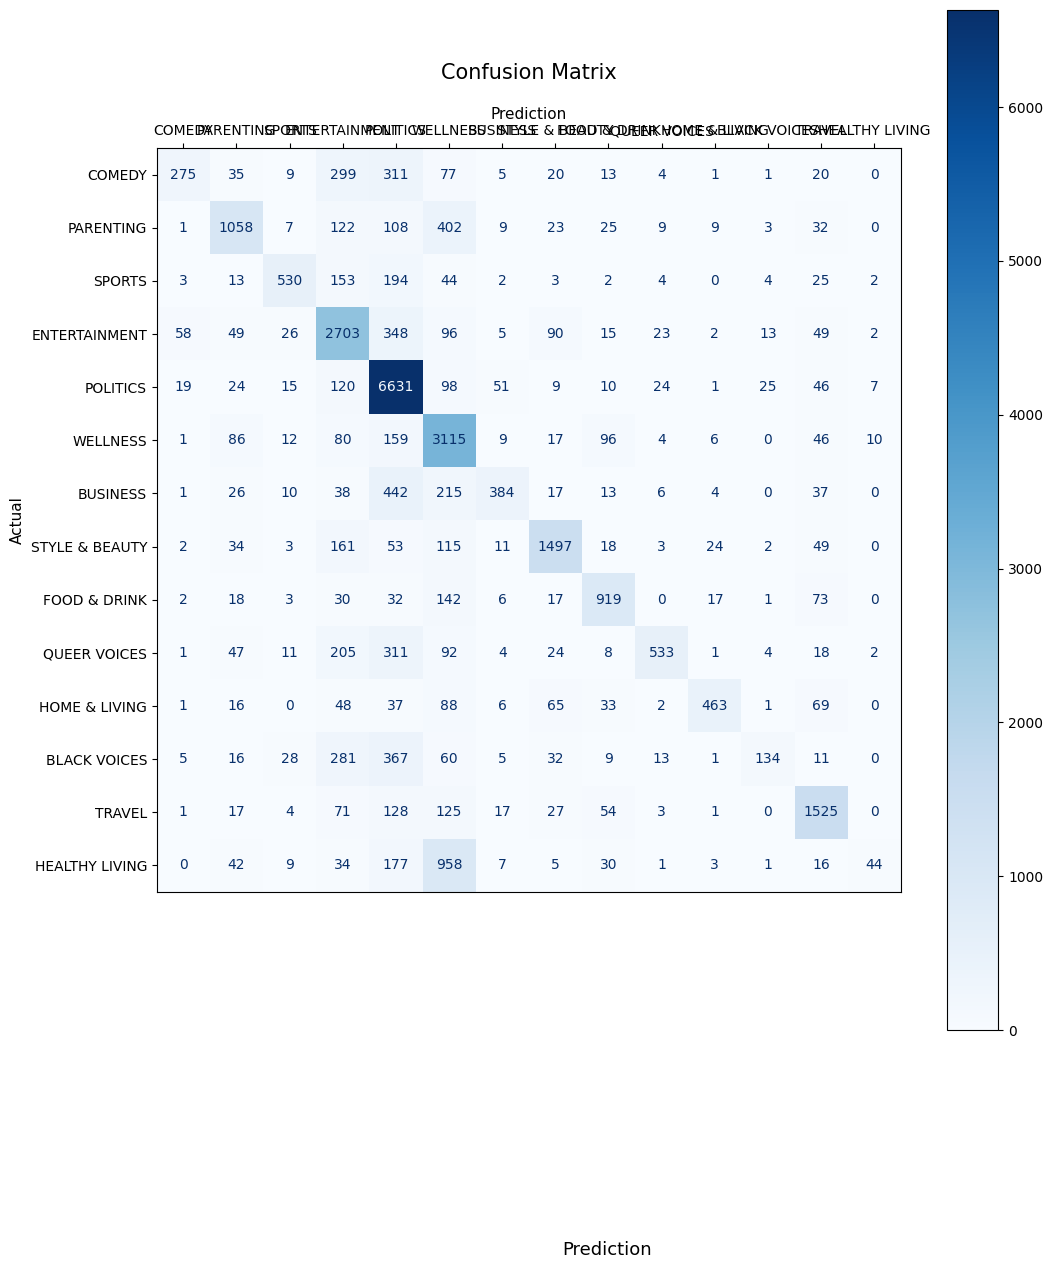

In [44]:
#confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(12, 15))
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()
